# El uso del bootstrapping en la valoración como ejemplo del desarrollo de elementos de política crediticia para un banco pequeño

Cyrill A. Murashev, 2023-03-07

## Abstracto

Este material es la continuación de un ciclo de trabajo sobre el tema de los métodos de remuestreo. Hablamos del método jackknife en el [artículo anterior](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Jackknife/jackknife-esp.ipynb). Hoy examinaremos el método más popular y universal del bootstrapping. No sería exagerado decir que el bootstrapping es una de las piedras angulares de la ciencia de datos moderna, junto con, por ejemplo, la regresión lineal o el análisis ROC. Este material se ha desarrollado específicamente para tasadores, por lo que estudiaremos el tema desde el punto de vista de su utilidad práctica en la práctica de los préstamos con garantía.

Imaginemos un pequeño banco que opera en Europa del Este. Su dirección se ha fijado el objetivo de desarrollar un sistema de normas para la política crediticia del banco. Una de ellas debe resolver la tarea de determinar el precio máximo de la propiedad hipotecada, que es seguro para la estabilidad financiera del banco. Se decidió tener en cuenta la realidad moderna, especialmente los últimos logros en el mundo de la inteligencia artificial, así como los requisitos de la [IFRS 13 "Fair Value Measurement"](https://www.ifrs.org/issued-standards/list-of-standards/ifrs-13-fair-value-measurement/). Así, se decidió minimizar la influencia de los factores subjetivos y maximizar la de los métodos científicos. Dado que las capacidades de las pequeñas instituciones financieras son bastante limitadas, no existe la posibilidad de aplicar métodos de IA a gran escala basados en big data reales. En su lugar, es razonable implementar algunas soluciones locales basadas en el aprendizaje automático y aplicarlas a la muestra de tamaño medio.

Es muy importante comprender lo siguiente
1. estamos tratando con una muestra de datos, no con la totalidad de los datos del mercado;
1. nuestro objetivo es estimar algunos parámetros del mercado, no sólo de la muestra.
Hay otra premisa fundamental que debe entenderse cuando se analizan datos de mercado. Los tasadores casi nunca conocen la distribución de una característica en los datos de mercado. Por lo tanto, trabajan con una distribución desconocida, lo que impone algunas limitaciones a la aplicación de los enfoques estadísticos clásicos basados en hipótesis relacionadas con la forma de la distribución.

En este contexto, debemos aplicar algunos métodos especiales que pueden ayudarnos a aproximar las estimaciones de los parámetros realizadas para la muestra a los verdaderos valores que existen en el mercado considerado. También deben estar libres de la forma de la distribución.

Hoy exploraremos el método de bootstrapping en sus implementaciones básicas y en algunas algo más sofisticadas. Nos permite mejorar casi cualquier estimación realizada para la muestra y reducir su sesgo con respecto al valor real que existe en el mercado, independientemente de la distribución de la característica en la muestra inicial.

## Declaración de tareas y aportaciones clave

Como ya hemos mencionado, nuestra tarea de formación consiste en desarrollar algunos aspectos de la política de crédito de un banco. Imaginemos un mercado local de bienes inmuebles. El banco suele conceder préstamos garantizados por esta propiedad. En este caso, una de las tareas consiste en establecer límites para el importe máximo posible del préstamo, así como el valor máximo seguro de la garantía. Ambas condiciones están condicionadas por la necesidad de limitar las pérdidas potenciales. Y la segunda también está condicionada por la escasa liquidez de los objetos atípicos, incluidos aquellos cuyo precio absoluto o unitario es demasiado elevado. Además, las compañías de seguros suelen tener sus propios límites, y no aceptarían el riesgo de un pago excesivo del seguro, trasladándolo al asegurado en la parte de superación del límite. Por lo tanto, es razonable fijar el límite superior de la propiedad hipotecada. En este caso, la propiedad con un valor inferior al límite se aceptaría como garantía por su valor total. Y una propiedad con un valor superior al límite se aceptaría por el valor límite. Esto se aplica tanto a los valores totales como a los unitarios. En algunos casos, también tendría sentido limitar el precio mínimo.

Para lograr un equilibrio entre seguridad financiera y rentabilidad, la mejor opción es determinar los valores de mercado de los límites seguros. Esta tarea requiere la estimación de ciertos parámetros específicos de todo el mercado. Dado que sólo disponemos de una muestra, debemos aplicar algunos métodos especiales que nos ayudarán a corregir el sesgo entre las estimaciones de la muestra y las de la población. Ahora podemos crear un sistema de reglas. 
1. El límite superior del valor total de la propiedad es igual a la expectativa más una desviación típica.
1. El límite superior del valor unitario de la propiedad es igual a la expectativa más dos desviaciones típicas.

Los valores específicos de la desviación típica podrían desplazarse en un sentido u otro, en función de los objetivos de un banco.

A continuación, estimaremos los valores de los parámetros necesarios. Debemos estimar los valores verdaderos de los cuatro parámetros: valores de mercado totales y unitarios, así como sus desviaciones típicas. Como ya hemos dicho, no podemos obtener los valores verdaderos directamente porque estamos trabajando con muestras. Por lo tanto, utilizaremos el método de bootstrapping, que nos permite reducir el sesgo de las estimaciones muestrales en relación con los valores verdaderos que existen en la población.

## Descripción del método

### Declaraciones generales sobre el Bootstrapping

**Bootstrapping** es una técnica de muestreo aleatorio con sustitución. Pertenece a la clase más amplia de métodos de remuestreo. Esta técnica puede utilizarse para estimar la distribución muestral de casi cualquier estadística.

En la práctica, al analizar datos, los tasadores casi siempre se enfrentan a la necesidad de estimar la varianza y los intervalos de confianza de alguna medida. Es difícil hacer inferencias útiles basándose únicamente en estimaciones puntuales. Por lo tanto, es muy útil poder estimar los intervalos de confianza de cualquier indicador. La estadística clásica nos dice que podemos, por ejemplo, estimar intervalos de confianza para la media bajo ciertos supuestos. Pero no da una respuesta sencilla a la pregunta de qué hacer si se violan estos supuestos. Estimar intervalos de confianza para la mediana es un problema mucho más complejo en sí mismo. Así que necesitamos un método universal que nos permita estimar casi cualquier parámetro y obtener su varianza y sus intervalos de confianza, independientemente de cualquier suposición sobre la distribución de ese parámetro.

El método de bootstrapping resuelve con éxito el problema de obtener valores de dichos indicadores independientemente de la distribución de los datos. Además, permite mejorar cualquier estimación muestral, acercando sus valores a los verdaderos valores de la población.

Imaginemos que existe una población general que tiene *N* elementos. Pero sólo tenemos una muestra de tamaño *n*. Si *N* y *n* son iguales, podemos obtener cualquier parámetro directamente de la muestra. En la práctica, *n* es casi mucho menor que *N*. Así que necesitamos aplicar alguna función **'F(X)'** para obtener estimaciones de algún parámetro para la muestra. En el caso de que conozcamos la distribución del parámetro en la población general, podemos utilizar la estimación puntual obtenida. Pero lo más frecuente es que no conozcamos esta distribución. En este caso, la estimación puntual resultante no nos resulta suficientemente útil. El hecho es que no podemos correlacionarla de algún modo con el verdadero valor del parámetro para toda la población general. Así que necesitamos obtener de algún modo no sólo la estimación, sino también su distribución esperada en la población. Es decir, deberíamos obtener un conjunto de estimaciones como si tuviéramos muchas muestras. Pero sólo tenemos una muestra. Así que necesitamos algún tipo de remuestreo. El resumen de lo anterior se muestra en la siguiente figura.

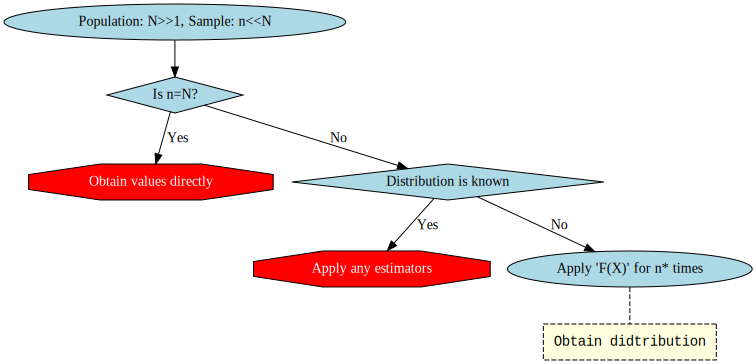

In [5]:
from flowgiston import *
Base = flowgiston_base(fillcolor='lightblue')
class Yes(Base):
    fillcolor = 'Red'
    fontcolor = 'white'
    shape = 'octagon'

class Note(Base):
    fillcolor = 'lightyellow'
    style = 'filled,dashed'
    shape = 'box'
    fontname = 'courier'

chart = FlowgistonChart(Base)

sample = chart.start("Population: N>>1, Sample: n<<N").edge(chart.if_("Is n=N?"))
sample.yes(chart.Yes.node("Obtain values directly"))
distribution = sample.no(chart.if_("Distribution is known"))
distribution.yes(chart.Yes.node("Apply any estimators"))
end = distribution.no(chart.end("Apply 'F(X)' for n* times")).edge(chart.Note.node("Obtain didtribution"), style='dashed', dir='none')
chart

Veamos un ejemplo. Necesitamos encontrar la distribución del siguiente parámetroer
$$\frac{\overline{x}-\mu}{\frac{S}{\sqrt{n}}}.$$

Basándonos en el diagrama de flujo anterior, nos vemos obligados a rechazar la estimación directa. Entonces podemos elegir entre el enfoque estadístico clásico y el remuestreo. El primero requiere que conozcamos la distribución. O podemos hacer algunas suposiciones sobre la distribución. Por ejemplo, podemos suponer que la característica estimada tiene una distribución normal en la población general. Entonces nuestro parámetro tendría la **t-distribución**. Pero no tenemos respuesta a lo que ocurriría si nuestras suposiciones fueran erróneas.

En la práctica de la valoración, casi siempre desconocemos la distribución de una característica en el mercado y no podemos hacer conjeturas fiables al respecto. El bootstrapping puede ayudarnos en estos casos. La idea es la siguiente. Sólo tenemos una muestra. Por lo tanto, sólo podemos obtener la estimación puntual del parámetro. Pero si pudiéramos obtener un cierto número de muestras de la población general, también podríamos obtener la distribución del parámetro en ellas. Esto, a su vez, nos permitiría obtener los intervalos de confianza del parámetro, independientemente de cualquier supuesto. En la práctica, no podemos obtener nuevas muestras sin pérdidas de tamaño. Pero podemos simular nuevas pseudo-muestras como si pudiéramos obtener algunas muestras de la población.

Si nuestra muestra es lo suficientemente grande, su distribución es hasta cierto punto un reflejo de la distribución en la población general. Este hecho nos permite dar un paso importante en la comprensión del concepto de bootstrapping, así como del concepto general de remuestreo. El enfoque estadístico clásico se basa en una suposición previa sobre la forma de la distribución en la población general. Los métodos de remuestreo, en cambio, suponen que la distribución en la población general es aproximadamente la misma que la distribución de muestreo. En un sentido más general, podemos decir que el método consiste en trabajar con la muestra como si fuera la población general. Tomamos una muestra y suponemos que refleja la distribución de la población. A continuación, aplicamos algunas técnicas de remuestreo. A continuación, utilizamos la función para calcular los estadísticos que nos interesan. Como resultado, extendemos las conclusiones extraídas de la muestra a toda la población. La técnica descrita parece un poco recursiva. Sin embargo, funciona muy bien en la práctica.

### La técnica del bootstrapping

#### Obtener intervalos de confianza

Consideremos un caso sencillo, cuya versión más avanzada será útil para nuestra tarea principal. Tenemos una muestra $X[x_{1}\ldots x_{n}]$ y queremos encontrar el intervalo de confianza para la media. Por supuesto, no tenemos ningún problema para calcular la media muestral. Sin embargo, es sólo un número que se refiere únicamente a la muestra en sí. El enfoque clásico nos dice que podemos obtener el intervalo de confianza a partir de este valor. Pero sólo si se conoce la distribución. En la práctica, no tenemos ni idea de cuál es la verdadera distribución en el mercado. Por lo tanto, es muy probable que el intervalo de confianza calculado sea engañoso. En su lugar, supondremos que la muestra es bastante representativa y refleja en cierta medida la verdadera distribución en la población. A continuación, daremos los siguientes pasos.
11. Tomamos nuestra muestra y utilizamos el muestreo aleatorio con reemplazamiento para crear una nueva muestra del mismo tamaño. Esto significa que una o más observaciones de la muestra original pueden repetirse cualquier número de veces en la nueva muestra.
1. Repita el paso anterior al menos mil veces. Cuantas más veces se repita este proceso, mejor será el resultado. Por lo tanto, el límite superior de repeticiones sólo lo fija la potencia de cálculo.
1. Introduzcamos una nueva notación y etiquetemos la nueva muestra como $X^{*}$. Así que ahora tenemos un conjunto de $X^{*}$ de $X_{1}^{*}$ a $X_{B}^{*}$.
1. Calcular la estadística de interés para cada $X^{*}$. En nuestro caso, será la media. Esto nos dará un conjunto de valores $\overline{X_{1}^{*}},\ldots,\overline{X_{B}^{*}}$.
1. Es fácil ver que ahora tenemos la distribución de la estadística de interés. Esto nos permite trabajar con ella como lo haríamos con cualquier distribución conocida. Por ejemplo, podemos establecer cuantiles de interés y calcular el intervalo de confianza, que era nuestro objetivo original.

El algoritmo anterior nos permite proporcionar una implementación del **bootstrap de percentiles**. Es el tipo de bootstrap más sencillo e intuitivo. Pero tiene algunas limitaciones. La principal es que esta técnica sólo puede manejar bien distribuciones simétricas. La técnica más sofisticada pero también más universal es el **bootstrap básico**. Este enfoque utiliza una técnica ligeramente diferente. Tiene los mismos dos primeros pasos. Pero en el tercer paso calculamos un estadístico diferente:$\overline{X} - \overline{X_{i}^{*}}$. Como resultado, obtenemos la distribución de la siguiente estadística
$$\overline{X} - \overline{X_{i}^{*}}.$$
Su idea principal es que debemos conseguir lo siguiente gracias a un gran número de muestras repetidas 
$$\mu - \overline{X} \approx \overline{X} - \overline{X^{*}}.$$
Vamos a etiquetar la distribución de $\mu - \overline{X}$ as $\beta$. Si conociéramos alfa, podríamos obtener sus cuantiles, por ejemplo $\beta_{0,025}, \beta_{0,975}$. Esto significa que podríamos estimar la probabilidad de lo siguiente
$$
P\left(\mu-(\overline{x}) \in [\beta_{0.025}, \beta_{0.975}]\right).
$$
Por supuesto, para la beta conocida, la probabilidad es 0,95. La ecuación anterior puede reescribirse como sigue
$$\begin{cases}
\mu-\overline{x} \leq \beta_{0.975}\\
\mu-\overline{x} \geq \beta_{0.025}.
\end{cases}
$$
Nos permite saber que
$$
P\left(\mu \in [\beta_{0.025}+\overline{x}, \beta_{0.975}++\overline{x}]\right).
$$
Así, obtenemos la distribución de la población por aproximación bootstrap y estimamos los intervalos de confianza.

#### Comprobación de hipótesis

La universalidad del bootstrapping es que permite no sólo obtener una estadística, sino también probar hipótesis. Veamos un ejemplo. Tengamos dos muestras: $X=x_{1},\ldots,x_{n}$ e $Y=y_{1},\ldots,y_{m}$. Y queremos probar si las expectativas de X e Y son iguales: $u_mu_{X}=\mu_{Y}\ -\ ?$. Sin embargo, todo lo que podemos obtener son las medias muestrales. La conocida prueba t-puede hacer el trabajo, pero también tiene una limitación bien conocida. Se basa en el supuesto de una distribución normal de la característica en ambas muestras. Sin embargo, nuestras distribuciones son desconocidas. Bootstrapping nos ayudará a superar esta limitación. El planteamiento básico es el mismo que en la estadística clásica. Construimos hipótesis nulas y alternativas. A continuación, estimamos la distribución de la estadística resultante para el caso en que la hipótesis nula sea cierta. Pero las hipótesis en sí son un poco exóticas. La hipótesis nula es que las distribuciones de *X* y *Y* son iguales.
1. Combina las dos muestras en una, manteniendo los datos sobre el origen de cada observación.
1. Genere una nueva muestra de tamaño *m+n* mediante un nuevo muestreo con reemplazamiento.
1. Dividirla en dos muestras por el rasgo de origen.
1. Calcular $\overline{X_{i}^{*}}$ y $\overline{Y_{j}^{*}}$.
1. Restar $\overline{Y_{j}^{*}}$ de $\overline{X_{i}^{*}}$.
1. Repita los pasos 2 a 5 *k* veces *(k>1000)*.
1. Ahora tenemos la distribución de las diferencias entre $X^{*}$ y $Y^{*}$.
1. Todo lo que necesitamos ahora es restar Y de X y encontrar la probabilidad *(valor p)* de tal diferencia para nuestra distribución obtenida en el paso anterior.
1. A continuación, comparamos el p-valor con el $\alpha$ (el más común es 0,05) y tomamos la decisión de rechazar o no la hipótesis nula.

Los dos últimos pasos no difieren del enfoque clásico de las pruebas de hipótesis.

### Tipos de técnicas de bootstrapping

Hay muchas maneras de hacer bootstrap. Hoy solo veremos las tres que deberían ser suficientes para la primera inmersión de un tasador en el aprendizaje automático.

#### Bootstrap básico

##### Concepto general

El bootstrap básico es una técnica estadística para estimar la distribución de una estadística muestral, como la media o la desviación típica, a partir de una única muestra de datos. El método bootstrap básico consiste en volver a muestrear la muestra original con reemplazo para crear numerosas muestras simuladas, calcular la estadística de interés para cada muestra simulada. A continuación, se utiliza la distribución de estos estadísticos simulados para estimar la distribución del estadístico de interés.

A continuación se describe paso a paso el método bootstrap básico.
1. Tome una muestra aleatoria de tamaño n de la población de interés.
1. Extraiga numerosas muestras aleatorias de tamaño *n* de la muestra original con reemplazamiento. Esto significa que, para cada muestra, se seleccionan aleatoriamente *n* observaciones de la muestra original, y cada observación puede seleccionarse más de una vez.
1. Para cada muestra simulada, calcule la estadística de interés (por ejemplo, la media o la desviación típica).
1. Estime la distribución de la estadística de interés mediante el cálculo de la media, la desviación típica o los intervalos de confianza de las estadísticas simuladas.

El método bootstrap básico es útil cuando se dispone de un tamaño de muestra pequeño o cuando no se puede suponer que la población se distribuye normalmente. Puede utilizarse para estimar la incertidumbre asociada a una estadística muestral, para comparar diferentes grupos o condiciones, o para probar hipótesis sobre la población.

Es importante señalar que el método bootstrap básico presupone que la muestra original es representativa de la población de interés y que las observaciones de la muestra son independientes y están idénticamente distribuidas. Si no se cumplen estos supuestos, los resultados del bootstrap pueden no ser exactos.

##### Ventajas y desventajas

**Ventajas** del bootstrap básico.
1. No paramétrico: El método bootstrap básico no hace ninguna suposición sobre la distribución de la población y, por lo tanto, es un método no paramétrico. Esto lo convierte en una herramienta útil para analizar datos que pueden no seguir una distribución normal.
1. Flexibilidad: El método bootstrap básico puede aplicarse a una amplia gama de estadísticas, como medias, varianzas y proporciones. Esto lo convierte en una herramienta versátil para muchos tipos de preguntas de investigación.
1. Tamaño de la muestra: El método bootstrap básico es especialmente útil cuando el tamaño de la muestra es pequeño. Al generar múltiples muestras a partir de los datos originales, el método puede proporcionar estimaciones más precisas de los parámetros de la población.
1. Intervalos de confianza: El método bootstrap básico puede utilizarse para estimar intervalos de confianza para los parámetros de la población, lo que puede ayudar a cuantificar la incertidumbre asociada a las estimaciones.

**Desventajas** del bootstrap básico.
1. Cálculo intensivo: El método bootstrap básico requiere generar numerosas remuestreos, lo que puede ser computacionalmente intensivo y consumir mucho tiempo, especialmente para grandes conjuntos de datos.
1. Sesgo: El método bootstrap básico puede estar sesgado si la muestra original no es representativa de la población. Esto puede dar lugar a estimaciones inexactas de los parámetros de la población.
1. Dependencia de los datos: El método bootstrap básico asume que las observaciones de la muestra original son independientes y están idénticamente distribuidas. Si no se cumple este supuesto, los resultados del bootstrap pueden no ser exactos.
1. Precisión: La precisión del método bootstrap básico depende del número de remuestreos generados. Si el número de remuestreos es demasiado pequeño, los resultados pueden no ser fiables. Sin embargo, la generación de numerosas remuestreos puede ser intensiva desde el punto de vista informático, como se ha mencionado anteriormente.

#### Bootstrap suavizado

##### Concepto general

Uno de los problemas del bootstrap básico es que puede producir estimaciones demasiado variables o inestables, sobre todo cuando el tamaño de la muestra es pequeño o la distribución de los datos está muy sesgada o tiene colas gruesas. El bootstrap suavizado es una modificación del bootstrap básico que aborda este problema añadiendo un paso de suavizado al proceso de remuestreo.

En el bootstrap suavizado, en lugar de tomar muestras directamente del conjunto de datos original, primero ajustamos una función de densidad de probabilidad (FDP) a los datos utilizando un estimador de densidad de núcleo (DDN) o un método similar. A continuación, muestreamos a partir de esta FDP para generar las muestras bootstrap, en lugar de muestrear directamente a partir del conjunto de datos original. Esto tiene el efecto de "suavizar" la distribución y puede ayudar a reducir la variabilidad de las estimaciones bootstrap.

Un enfoque común para implementar el bootstrap suavizado es utilizar el algoritmo de remuestreo de la siguiente manera:
1. Ajuste una función de densidad de probabilidad a los datos originales usando un estimador de densidad de núcleo o un método similar.
1. Genere numerosas muestras bootstrap tomando muestras de la FDP en lugar de tomarlas directamente de los datos.
1. Calcule el estadístico de interés para cada una de estas muestras bootstrap.
1. Calcule la media, la mediana, los IC, etc. de las estimaciones bootstrap resultantes para obtener la estimación final de la estadística.
1. Calcule la media, la mediana, los IC, etc. de las estimaciones bootstrap resultantes para obtener la estimación final de la estadística.

El paso de suavizado puede ajustarse para equilibrar la relación sesgo-varianza en el procedimiento de estimación. Un mayor grado de suavizado conduce a una estimación más sesgada, pero con menor varianza, mientras que un menor grado de suavizado conduce a una estimación menos sesgada pero con mayor varianza. La elección del parámetro de suavizado depende de la aplicación específica y de las características de los datos.

##### Ventajas y desventajas

**Ventajas** del bootstrap suavizado.
1. Variabilidad reducida: La principal ventaja del bootstrap suavizado es que puede reducir la variabilidad de las estimaciones del bootstrap en comparación con el bootstrap básico. Esto es especialmente útil cuando el tamaño de la muestra es pequeño o la distribución de los datos está muy sesgada o tiene colas pesadas.
1. Estimaciones más precisas: El paso de suavizado en el bootstrap suavizado también puede ayudar a producir estimaciones más precisas de la distribución subyacente de los datos, especialmente en casos en los que la distribución verdadera es desconocida o difícil de estimar.
1. Flexibilidad: El bootstrap suavizado es flexible y puede adaptarse a diferentes tipos de datos y modelos estadísticos. También puede utilizarse para estimar la distribución de estadísticos más complejos, como cuantiles o coeficientes de regresión.

**Desventajas** del bootstrap suavizado.
1. Sesgo: El paso de suavizado en el bootstrap suavizado puede introducir un sesgo en las estimaciones, especialmente si el parámetro de suavizado es demasiado alto. Este sesgo puede ser difícil de cuantificar y corregir.
1. Complejidad: El bootstrap suavizado puede ser más intensivo computacionalmente que el bootstrap básico, especialmente si el paso de suavizado implica ajustar un modelo complejo o estimar numerosos parámetros.
1. Dependencia del parámetro de suavizado: La elección del parámetro de suavizado en el bootstrap suavizado puede tener un impacto significativo en la calidad de las estimaciones. Encontrar el parámetro de suavizado óptimo puede ser complicado y requerir pasos adicionales de ajuste o validación.
1. Posible pérdida de información: El paso de suavizado en el bootstrap suavizado también puede dar lugar a una pérdida de información sobre la distribución subyacente de los datos. Esto puede dificultar la realización de inferencias sobre la distribución real o la detección de características como valores atípicos o bimodalidad.

#### Bootstrap bayesiano

##### Concepto general

El bootstrap bayesiano es un método de remuestreo utilizado en la inferencia bayesiana que puede utilizarse para estimar la distribución posterior de un parámetro o modelo. Al igual que otros métodos bootstrap, el bootstrap bayesiano implica la generación de numerosas muestras a partir de los datos, pero lo hace en un contexto bayesiano.

En el bootstrap bayesiano, suponemos que los datos proceden de una distribución desconocida que puede describirse mediante una distribución a priori y una función de verosimilitud. A continuación, simulamos nuevos conjuntos de datos volviendo a muestrear el conjunto de datos original, pero en lugar de simplemente volver a muestrear los datos con reemplazo, también volvemos a muestrear la distribución a priori.

Más concretamente, el algoritmo bootstrap bayesiano puede resumirse como sigue.
1. Defina una distribución a priori para el parámetro o parámetros desconocidos o el modelo.
1. Calcular la función de verosimilitud de los datos dados los parámetros o el modelo.
1. Muestrear una nueva distribución a priori a partir de la distribución a priori original.
1. Muestree un nuevo conjunto de datos volviendo a muestrear el conjunto de datos original.
1. Calcule la distribución posterior del parámetro o parámetros o del modelo utilizando la nueva distribución a priori y la función de verosimilitud basada en el nuevo conjunto de datos.
1. Repita los pasos 3-5 para generar un gran número de distribuciones posteriores simuladas.

Las distribuciones posteriores resultantes pueden usarse para estimar la media, la varianza y otras características de la verdadera distribución posterior, así como para hacer afirmaciones probabilísticas sobre el parámetro o parámetros o el modelo.

Una ventaja del bootstrap bayesiano es que puede utilizarse con una amplia gama de distribuciones a priori y funciones de verosimilitud, lo que lo convierte en una herramienta versátil para la inferencia bayesiana. También puede usarse para estimar la distribución posterior de modelos complejos que no pueden resolverse analíticamente, y no requiere ninguna suposición sobre la forma de la distribución subyacente o la presencia de valores atípicos. Sin embargo, al igual que otros métodos de remuestreo, el bootstrap bayesiano puede ser intensivo desde el punto de vista computacional y puede requerir un gran número de simulaciones para producir estimaciones precisas de la distribución posterior.

##### Ventajas y desventajas

**Ventajas** del bootstrap bayesiano.
1. Flexibilidad: El bootstrap bayesiano es un método flexible que puede aplicarse a una amplia gama de modelos estadísticos y priors. Esto lo hace útil en muchas situaciones en las que otros métodos pueden no ser aplicables.
1. Sin suposiciones sobre la distribución subyacente: A diferencia de otros métodos, el bootstrap bayesiano no requiere ninguna suposición sobre la forma de la distribución subyacente o la presencia de valores atípicos.
1. Proporciona una distribución posterior completa: El bootstrap bayesiano proporciona una distribución posterior completa del parámetro o parámetros desconocidos o del modelo, en lugar de sólo una estimación puntual. Esto permite una comprensión más completa de la incertidumbre asociada a la estimación.
1. Maneja modelos complejos: El bootstrap bayesiano puede utilizarse para estimar la distribución posterior de modelos complejos que no pueden resolverse analíticamente.

**Desventajas** del bootstrap bayesiano.
1. Computacionalmente intensivo: El bootstrap bayesiano puede ser intensivo desde el punto de vista computacional, especialmente para grandes conjuntos de datos o modelos complejos. Esto puede hacer que sea poco práctico en algunas situaciones en las que otros métodos pueden ser más rápidos.
1. Puede ser sensible a la elección de la prioridad: El bootstrap bayesiano depende de la elección de la distribución a priori. La elección de la distribución a priori puede afectar a los resultados del análisis, por lo que es importante elegir cuidadosamente una distribución a priori que sea adecuada para el problema que se está estudiando.
1. Puede no funcionar bien con muestras de pequeño tamaño: El bootstrap bayesiano puede ser sensible a tamaños de muestra pequeños, y puede no funcionar tan bien como otros métodos en situaciones en las que el tamaño de la muestra es muy pequeño.
1. Requiere cierta comprensión de la inferencia bayesiana: El bootstrap bayesiano es un método dentro de la inferencia bayesiana y requiere cierta comprensión de los principios y conceptos bayesianos para utilizarlo eficazmente. Esto puede limitar su uso en algunos campos o aplicaciones en los que los usuarios no estén familiarizados con los métodos bayesianos.

## Aplicación práctica

### Problemas comunes

Volvamos a nuestra tarea de aprendizaje y calculemos los valores reales del mercado para ayudar al banco a diseñar su política de crédito. Utilizaremos el conjunto de datos reales con 2355 observaciones en uno de los mercados. Hoy tenemos las dos columnas de interés: 'price' y 'price_m'. La primera contiene datos sobre los precios de los propios objetos inmobiliarios, y la segunda sobre sus precios por metro cuadrado. En el primer paso, realizamos algunos pasos técnicos y calculamos las estimaciones de la muestra.

In [6]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from scipy.stats import norm
from scipy.stats import scoreatpercentile

In [3]:
# create function for easy calculation of sample standard deviation
def appr_sam_std(a, ddof = 1):
    return np.std(a, ddof = ddof)

In [4]:
# import data
data = pd.read_csv("ds.csv", index_col=False)

# calculate statistics for the "general population"
tp_sample_mean   = data['price'].mean()
up_sample_mean   = data['price_m'].mean()
tp_sample_std    = data['price'].std()
up_sample_std    = data['price_m'].std()
formatted_tp_sample_mean = '{:.2f}'.format(tp_sample_mean)
formatted_up_sample_mean = '{:.2f}'.format(up_sample_mean)
formatted_tp_sample_std  = '{:.2f}'.format(tp_sample_std)
formatted_up_sample_std  = '{:.2f}'.format(up_sample_std)
print("The sample mean price is", formatted_tp_sample_mean)
print("The sample mean unit price is", formatted_up_sample_mean)
print("The sample standard deviation of price is", formatted_tp_sample_std)
print("The sample standard deviation of unit price is", formatted_up_sample_std)

The sample mean price is 23372356.69
The sample mean unit price is 361554.02
The sample standard deviation of price is 16061866.51
The sample standard deviation of unit price is 95947.20


Ahora podemos pasar al bootstrapping. Existen algunas funciones de biblioteca para ello, pero hoy crearemos nuestras propias funciones para comprender mejor la naturaleza de las técnicas. Crearemos e implementaremos funciones para los siguientes tipos de bootstrapping:
1. bootstrap básico;
1. bootstrap suavizado;
1. bootstrap bayesiano.

No existe un único "mejor" tipo de bootstrap, ya que la elección del método a utilizar depende del problema concreto que se plantee y de los objetivos del análisis. El bootstrap básico y el bootstrap percentil son dos de los métodos más usados, pero también existen otras variantes del bootstrap, como el bootstrap con corrección de sesgo y acelerado (BCa) y el bootstrap estudiado.

El bootstrap básico es el método más sencillo y directo, ya que consiste en muestrear repetidamente los datos originales con reemplazo y calcular la estadística de interés en cada muestra bootstrap. Este método suele ser adecuado para estimar la distribución muestral de estadísticas sencillas, como la media o la varianza, y es relativamente fácil de aplicar.

El bootstrap percentil es un método más sofisticado que consiste en calcular el intervalo de confianza de la estadística de interés utilizando los percentiles empíricos de la distribución bootstrap. Este método suele preferirse cuando la distribución muestral de la estadística no es normal o el tamaño de la muestra es pequeño, ya que proporciona intervalos de confianza más precisos y es menos sensible a la distribución subyacente de los datos.

El bootstrap BCa es una variante del bootstrap percentil que ajusta el sesgo y la asimetría de la distribución del bootstrap, y suele ser más preciso que el bootstrap básico y percentil para muestras pequeñas o cuando la distribución subyacente está muy sesgada. Sin embargo, puede ser más intensivo desde el punto de vista computacional y requiere conocimientos estadísticos más avanzados para su aplicación.

El bootstrap estudiado es un método que consiste en estandarizar la estadística de interés por su error estándar estimado y, a continuación, volver a muestrear a partir de una t-distribución con grados de libertad iguales al tamaño de la muestra menos uno. Este método suele preferirse cuando la estadística de interés es un cociente o la diferencia de dos estimaciones, o cuando la distribución de la estadística está muy sesgada o tiene muchas colas.

En resumen, la elección del tipo de bootstrapping depende del problema concreto y de los objetivos del análisis, así como de los recursos informáticos disponibles y de los conocimientos estadísticos del analista. Suele ser una buena idea comparar los resultados de varios métodos de bootstrapping para asegurarse de que las conclusiones son sólidas y no demasiado sensibles a la elección del método.

###  Bootstrap básico

El código siguiente define una función **'appr_basic_bootstrap'** que realiza un bootstrap básico en un conjunto de datos para calcular un estadístico y sus intervalos de confianza utilizando el método asintótico.

La función recibe cinco argumentos:
1. data: un conjunto de datos de entrada en forma de matriz
1. num_samples: el número de muestras bootstrap a generar
1. sample_size: el tamaño de cada muestra bootstrap, por defecto el tamaño del conjunto de datos de entrada
1. stat_func: el estadístico a calcular en cada muestra bootstrap, por defecto la media
1. ci: intervalo de confianza a calcular, por defecto 95%.

La función comprueba primero si sample_size es None, si es así, establece sample_size a la longitud de los datos. A continuación, calcula el estadístico_original aplicando stat_func a los datos de entrada. A continuación, genera num_samples muestras bootstrap de tamaño sample_size eligiendo aleatoriamente elementos de los datos con reemplazo usando np.random.choice.

Calcula el stat_func para cada muestra bootstrap utilizando np.apply_along_axis y almacena los valores resultantes en bootstrap_statistics. A continuación, calcula la media de todos los valores stat_func de las muestras bootstrap para obtener bootstrap_statistic.

Por último, calcula los valores ci_lower y ci_upper para el intervalo de confianza utilizando **scipy.stats.scoreatpercentile** con valores alfa de (100 - ci) / 2 y 100 - (100 - ci) / 2, respectivamente.

La función devuelve una tupla que contiene 'bootstrap_statistic', 'ci_lower' y 'ci_upper'.

In [5]:
def appr_basic_bootstrap(data, stat_func=np.mean, num_samples=2000, sample_size=None, ci=95):
    """
    Perform basic bootstrap on a dataset to calculate a statistic and its confidence intervals.

    Parameters:
        data (array-like): The input dataset.
        num_samples (int): The number of bootstrap samples to generate.
        sample_size (int): The size of each bootstrap sample. Defaults to the size of the input dataset.
        stat_func (function): The statistic to calculate on each bootstrap sample. Defaults to the mean.
        ci (int): The confidence interval to calculate. Defaults to 95%.

    Returns:
        A tuple containing the calculated statistic and its confidence interval.
    """
    if sample_size is None:
        sample_size = len(data)

        
    # Calculate the statistic on the original dataset
    original_statistic = stat_func(data)    
        
    # Generate bootstrap samples
    bootstrap_samples = np.random.choice(data, size=(num_samples, sample_size), replace=True)

    # Calculate the statistic on each bootstrap sample
    bootstrap_statistics = np.apply_along_axis(stat_func, axis=1, arr=bootstrap_samples)
    
    # Calculate the mean of all statistic's values
    bootstrap_statistic = np.mean(bootstrap_statistics)
    
    # Calculate the confidence interval
    alpha = (100 - ci) / 2
    ci_lower = scoreatpercentile(bootstrap_statistics, alpha)
    ci_upper = scoreatpercentile(bootstrap_statistics, 100 - alpha)

    return bootstrap_statistic, ci_lower, ci_upper

Ahora vamos a aplicarlo a nuestros datos.

In [6]:
# apply the 'appr_basic_bootstrap' function to data
tp_basic_bootstrap_mean = appr_basic_bootstrap(data['price'])
tp_basic_bootstrap_std  = appr_basic_bootstrap(data['price'], stat_func = appr_sam_std)
up_basic_bootstrap_mean = appr_basic_bootstrap(data['price_m'])
up_basic_bootstrap_std  = appr_basic_bootstrap(data['price_m'], stat_func = appr_sam_std)

# extract single balues from tuple
tp_basb_mean, tp_basb_mean_lowCI, tp_basb_mean_upperCI = tp_basic_bootstrap_mean
tp_basb_std, tp_basb_std_lowCI, tp_mean_basb_upperCI = tp_basic_bootstrap_std
up_basb_mean, up_basb_mean_lowCI, up_basb_mean_upperCI = up_basic_bootstrap_mean
up_basb_std, up_basb_std_lowCI, up_mean_basb_upperCI = up_basic_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the basic bootstrap is {tp_basb_mean:.2f} \
with 95% confidence interval [{tp_basb_mean_lowCI:.2f}, {tp_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the basic bootstrap is {tp_basb_std:.2f} \
with 95% confidence interval [{tp_basb_std_lowCI:.2f}, {tp_mean_basb_upperCI:.2f}].')
print(f'The mean unit price obtained by the basic bootstrap is {up_basb_mean:.2f} \
with 95% confidence interval [{up_basb_mean_lowCI:.2f}, {up_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the basic bootstrap is {up_basb_std:.2f} \
with 95% confidence interval [{up_basb_std_lowCI:.2f}, {up_mean_basb_upperCI:.2f}].')

The mean price obtained by the basic bootstrap is 23370941.70 with 95% confidence interval [22727684.71, 24033931.00].
The standard deviation of the price obtained by the basic bootstrap is 16020188.92 with 95% confidence interval [14191560.87, 18008702.41].
The mean unit price obtained by the basic bootstrap is 361566.09 with 95% confidence interval [357732.73, 365501.65].
The standard deviation of the unit price obtained by the basic bootstrap is 95885.97 with 95% confidence interval [91171.64, 100680.84].


### Bootstrap suavizado

Definimos la función **smoothed_bootstrap**, que toma como entrada los datos, la función estadística de interés, el nivel deseado de intervalo de confianza y el número de muestras bootstrap a generar. La función devuelve la estimación bootstrap suavizada de la estadística y los límites inferior y superior del intervalo de confianza.

In [29]:
def appr_smoothed_bootstrap(data, statistic_func, alpha=0.05, n_bs_samples=2000):
    """
    Computes the smoothed bootstrap estimate and confidence intervals for a given statistic.
    
    Args:
    - data (array-like): the data from which to compute the statistic and confidence intervals
    - statistic_func (function): the function to compute the statistic of interest
    - alpha (float): the desired level of confidence interval (default 0.05)
    - n_bs_samples (int): the number of bootstrap samples to generate (default 1000)
    
    Returns:
    - bs_statistic (float): the smoothed bootstrap estimate of the statistic
    - ci_low (float): the lower bound of the confidence interval
    - ci_high (float): the upper bound of the confidence interval
    """
    
    # Compute the observed statistic
    obs_statistic = statistic_func(data)
    
    # Generate the bootstrap samples
    bs_samples = np.random.choice(data, size=(len(data), n_bs_samples))
    
    # Compute the bootstrap statistics
    bs_statistics = np.apply_along_axis(statistic_func, axis=0, arr=bs_samples)
    
    # Compute the standard deviation of the bootstrap statistics
    bs_std = np.std(bs_statistics)
    
    # Compute the smoothed bootstrap weights
    bs_weights = norm.pdf(bs_statistics - obs_statistic, scale=bs_std)
    
    # Compute the smoothed bootstrap estimate of the statistic
    bs_statistic = np.average(bs_statistics, weights=bs_weights)
    
    # Compute the confidence intervals
    bs_statistics_sorted = np.sort(bs_statistics)
    ci_low = bs_statistics_sorted[int(np.floor((alpha/2) * n_bs_samples))]
    ci_high = bs_statistics_sorted[int(np.ceil((1 - alpha/2) * n_bs_samples))]
    
    return bs_statistic, ci_low, ci_high


Aplicación a los datos.

In [35]:
# apply the 'appr_smoothed_bootstrap' function to data
tp_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price'], statistic_func = np.mean)
tp_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price'], statistic_func = appr_sam_std)
up_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price_m'], statistic_func = np.mean)
up_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price_m'], statistic_func = appr_sam_std)

# extract single balues from tuple
tp_smob_mean, tp_smob_mean_lowCI, tp_smob_mean_upperCI = tp_smoothed_bootstrap_mean
tp_smob_std, tp_smob_std_lowCI, tp_mean_smob_upperCI = tp_smoothed_bootstrap_std
up_smob_mean, up_smob_mean_lowCI, up_smob_mean_upperCI = up_smoothed_bootstrap_mean
up_smob_std, up_smob_std_lowCI, up_mean_smob_upperCI = up_smoothed_bootstrap_std

# output the result to the user
print(f'The mean price obtained by the smoothed bootstrap is {tp_smob_mean:.2f} \
with 95% confidence interval [{tp_smob_mean_lowCI:.2f}, {tp_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the smoothed bootstrap is {tp_smob_std:.2f} \
with 95% confidence interval [{tp_smob_std_lowCI:.2f}, {tp_mean_smob_upperCI:.2f}].')
print(f'The mean unit price obtained by the smoothed bootstrap is {up_smob_mean:.2f} \
with 95% confidence interval [{up_smob_mean_lowCI:.2f}, {up_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the smoothed bootstrap is {up_smob_std:.2f} \
with 95% confidence interval [{up_smob_std_lowCI:.2f}, {up_mean_smob_upperCI:.2f}].')

The mean price obtained by the smoothed bootstrap is 23376253.48 with 95% confidence interval [22768577.49, 23979150.74].
The standard deviation of the price obtained by the smoothed bootstrap is 16001329.71 with 95% confidence interval [14269520.65, 17909150.10].
The mean unit price obtained by the smoothed bootstrap is 361538.07 with 95% confidence interval [357495.87, 365667.21].
The standard deviation of the unit price obtained by the smoothed bootstrap is 95940.75 with 95% confidence interval [91305.76, 100445.92].


### Bootstrap bayesiano

La siguiente función recibe cuatro argumentos:
1. *X*, que es el conjunto de datos tipo array que se desea remuestrear;
1. *stat_func*, que es la función que desea aplicar a cada conjunto de datos remuestreado para calcular la estadística deseada (por defecto es np.mean);
1. *num_samples*, que es el número de muestras bootstrap a generar (por defecto es 2000);
1. *alpha*, que es el nivel de significación para el intervalo creíble (por defecto es 0.05);
1. *low_mem* establece la forma de generar los pesos (por defecto es False);
1. *resample_size* especifica el tamaño de la muestra remuestreada (por defecto es Ninguno).

La función calcula primero la función de distribución empírica (FED) de los datos, que se utiliza para generar muestras bootstrap a partir del bootstrap bayesiano. A continuación, aplica la función estadística a cada muestra bootstrap y calcula la estimación bayesiana bootstrap de la estadística tomando la media de las estadísticas bootstrap. Finalmente, calcula el intervalo creíble (1-alfa) encontrando los percentiles apropiados de las estadísticas bootstrap. Esta función es sólo una pequeña extensión de la [bayesian_bootstrap function](https://github.com/lmc2179/bayesian_bootstrap) de [Louis Cialdella](https://github.com/lmc2179).

In [36]:
def appr_bayesian_bootstrap(X, statistic=np.mean, n_replications=2000, resample_size=None, low_mem=False, alpha=0.05):
    """Simulate the posterior distribution of the given statistic.

    Parameter X: The observed data (array like)

    Parameter statistic: A function of the data to use in simulation (Function mapping array-like to number)

    Parameter n_replications: The number of bootstrap replications to perform (positive integer)

    Parameter resample_size: The size of the dataset in each replication
    
    Parameter low_mem(bool): Generate the weights for each iteration lazily instead of in a single batch. Will use
    less memory, but will run slower as a result.

    Returns: Statistoc for the samples from the posterior
    """
    
    if resample_size is None:
        resample_size = len(X)
    
    if isinstance(X, list):
        X = np.array(X)
    samples = []
    if low_mem:
        weights = (np.random.dirichlet([1] * len(X)) for _ in range(n_replications))
    else:
        weights = np.random.dirichlet([1] * len(X), n_replications)
    for w in weights:
        sample_index = np.random.choice(range(len(X)), p=w, size=resample_size)
        resample_X = X[sample_index]
        s = statistic(resample_X)
        samples.append(s)
        
    samples_sorted = sorted(samples)
    window_size = int(len(samples) - round(len(samples)*alpha))
    smallest_window = (None, None)
    smallest_window_length = float('inf')
    for i in range(len(samples_sorted) - window_size):
        window = samples_sorted[i+window_size-1], samples_sorted[i]
        window_length = samples_sorted[i+window_size-1] - samples_sorted[i]
        if window_length < smallest_window_length:
            smallest_window_length = window_length
            smallest_window = window
            
    posterior_statistic = np.mean(samples)         
            
    return posterior_statistic, smallest_window[1], smallest_window[0]

Aplicación a los datos.

In [38]:
# apply the 'appr_bayesian_bootstrap' function to data
tp_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price'])
tp_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price'], statistic = np.std)
up_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price_m'])
up_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price_m'], statistic = np.std)

# extract single balues from tuple
tp_bayb_mean, tp_bayb_mean_lowCI, tp_bayb_mean_upperCI = tp_bayesian_bootstrap_mean
tp_bayb_std, tp_bayb_std_lowCI, tp_mean_bayb_upperCI = tp_bayesian_bootstrap_std
up_bayb_mean, up_bayb_mean_lowCI, up_bayb_mean_upperCI = up_bayesian_bootstrap_mean
up_bayb_std, up_bayb_std_lowCI, up_mean_bayb_upperCI = up_bayesian_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the Bayesian bootstrap is {tp_bayb_mean:.2f} \
with 95% confidence interval [{tp_bayb_mean_lowCI:.2f}, {tp_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the Bayesian bootstrap is {tp_bayb_std:.2f} \
with 95% confidence interval [{tp_bayb_std_lowCI:.2f}, {tp_mean_bayb_upperCI:.2f}].')
print(f'The mean unit price obtained by the Bayesian bootstrap is {up_bayb_mean:.2f} \
with 95% confidence interval [{up_bayb_mean_lowCI:.2f}, {up_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the Bayesian bootstrap is {up_bayb_std:.2f} \
with 95% confidence interval [{up_bayb_std_lowCI:.2f}, {up_mean_bayb_upperCI:.2f}].')

The mean price obtained by the Bayesian bootstrap is 23373192.97 with 95% confidence interval [22497282.38, 24304543.52].
The standard deviation of the price obtained by the Bayesian bootstrap is 16014052.16 with 95% confidence interval [13464056.97, 18795443.99].
The mean unit price obtained by the Bayesian bootstrap is 361545.02 with 95% confidence interval [356060.67, 366479.47].
The standard deviation of the unit price obtained by the Bayesian bootstrap is 95910.03 with 95% confidence interval [89534.47, 103327.87].


### Aplicación de los resultados a la elaboración de los elementos de una política de crédito

Las tres técnicas nos dieron resultados similares. Así que podemos utilizar cualquiera de ellas sin dudarlo. Hoy usaremos los resultados del bootstrapping bayesiano. La media y la desviación típica posteriores del precio son, 23373192.97 y 16014052.16, respectivamente. La media y la desviación típica posteriores del precio unitario son, 361545,02 y 95910,03, respectivamente. Por lo tanto, podemos establecer las siguientes reglas de límites para la propiedad colateral.

||Minimum limit | Maximum limit | Mean| STD|
|:-|:-|:-|:-|:-|
|Price|**6,483,230.22**|**38,511,334.54**|23,373,192.97|16,014,052.16|
|Unit price|**169,724.96**|**553,365,08**|361,545.02|95,910.03|

El uso de estos límites puede proteger a un banco de aceptar garantías atípicas o ilíquidas.

## Resumen

Hoy hemos aprendido a superar los dos problemas básicos a los que se enfrentan a diario los tasadores:
1. el problema de las muestras pequeñas, que son mucho más pequeñas que todo el mercado;
2. el problema de la distribución desconocida.

El bootstrapping resuelve fácilmente estos dos problemas. El uso de técnicas de bootstrapping puede mejorar significativamente la calidad de los datos de mercado. En cierto sentido, puede decirse que es razonable utilizarlo siempre que el tasador disponga de al menos 20 ó 30 observaciones. 
Para debatir este o cualquier otro tema relacionado con el aprendizaje automático en valoración, te invito a unirte a mi [comunidad de Facebook](https://www.facebook.com/groups/1977067932456703) así como a mi [canal de Telegram](https://t.me/AIinValuation).